# Learning Z/nZ x Z/nZ group actions
This notebook is adapted from the `modular arithmetic` notebook, replacing `Z/nZ` group action with `Z/nZ x Z/nZ` group action 

In [1]:
import numpy as np
import random
import torch
import os
import torch.nn as nn
import torch.optim as optim
import shutil
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
import setcwd
setcwd.main()

import importlib
import pickle

import gagf.models as models
import gagf.datasets as datasets
import gagf.theory as theory
import gagf.train as train
import gagf.viz as viz


Git root path:  /home/adele/code/group-agf

Working directory:  /home/adele/code/group-agf/gagf
Directory added to path:  /home/adele/code/group-agf
Directory added to path:  /home/adele/code/group-agf/gagf/notebooks
Directory added to path:  /home/adele/code/group-agf/gagf/notebooks/saved_models


# Define Dataset and Visualize

Template mean: 0.13269649013023685


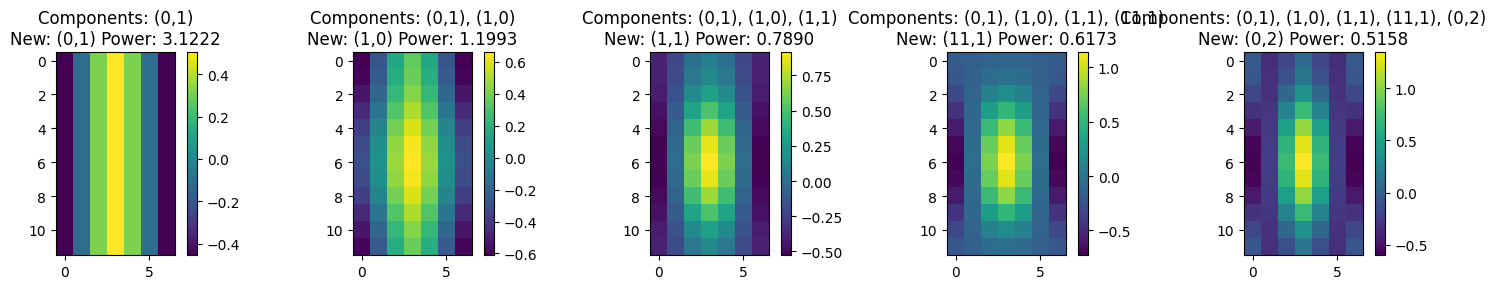

Translation for sample 4: a=(7, 11), b=(5, 4), a+b=(0, 3)


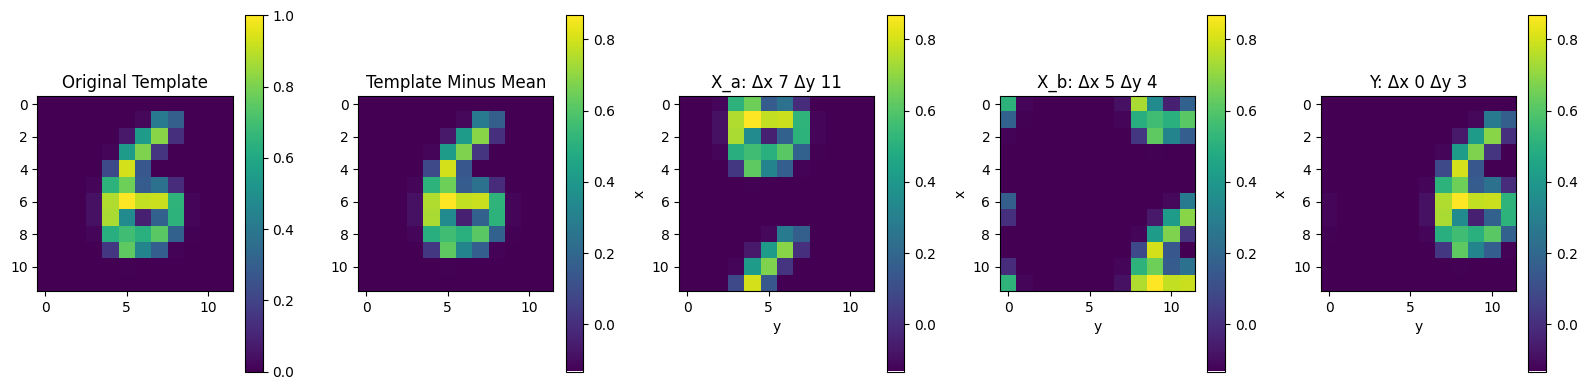

X_tensor shape: torch.Size([8295, 288]), Y_tensor shape: torch.Size([8295, 144])
GPU is available. Using CUDA.


In [ ]:
# Data Generation using the new function
p = 28  # Modulus

# Choose template
# template = generate_template(p, 2, 1.0)
# template = one_hot2D(p)
og_template = datasets.mnist_template(p, digit=6)
# og_template = datasets.generate_fixed_template(p)

print("Template mean:", np.mean(og_template))

# Mean center template
template = og_template - np.mean(og_template) # subtract the zeroth frequency

viz.plot_top_template_components(template, p)

# Generate dataset using numpy
X, Y, indices = datasets.ModularAdditionDataset2D(p, template, fraction=0.4)
viz.plot_template(X, Y, og_template, template, indices, p, i=4)

# Convert to PyTorch tensors
X_len = X.shape[-1]
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * X_len)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)
print(f"X_tensor shape: {X_tensor.shape}, Y_tensor shape: {Y_tensor.shape}")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

# Move tensors and model to the correct device if not already
X_tensor = X_tensor.to(device)
Y_tensor = Y_tensor.to(device)

## Gradient Descent Experiment

In [ ]:
seed = 10 #0  # or any integer you like

# Model parameters
n_frequencies_to_learn = 6
hidden_size = 6 * n_frequencies_to_learn  # 6 * size of group
init_scale = 1e-2 # 1e-2

# Optimizer parameters
lr, mom = 0.0001, 0.9 # originaly 0.01 and 0.9

# Training parameters
epochs = 10000#01
verbose_interval = 100
git_root_path = setcwd.get_root_dir()
# fig_save_dir = os.path.join(git_root_path, "notebooks", "figs_temp")
# print(f"Saving figures to {fig_save_dir}")

# Create a TensorDataset and DataLoader
batch_size = 128  # You can adjust this as needed
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Initialize model
model = models.TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=init_scale, output_scale=1e0)
model = model.to(device)

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom) # TODO: try adam optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(mom, 0.999))

# Model save path
model_save_path = os.path.join(git_root_path, "notebooks", "saved_models", "modular_addition_2D_model_tmp.pkl")

# Train the model with batches
loss_history, accuracy_history, param_history = train.train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=verbose_interval)

Epoch 100/10000, Loss: 0.0243, Accuracy: 12.45%
Epoch 200/10000, Loss: 0.0242, Accuracy: 8.98%
Epoch 300/10000, Loss: 0.0228, Accuracy: 0.00%
Epoch 400/10000, Loss: 0.0222, Accuracy: 0.00%
Epoch 500/10000, Loss: 0.0222, Accuracy: 0.00%
Epoch 600/10000, Loss: 0.0221, Accuracy: 0.00%
Epoch 700/10000, Loss: 0.0220, Accuracy: 0.00%
Epoch 800/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 900/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 1000/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 1100/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 1200/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 1300/10000, Loss: 0.0219, Accuracy: 0.00%
Epoch 1400/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 1500/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 1600/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 1700/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 1800/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 1900/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 2000/10000, Loss: 0.0218, Accuracy: 0.00%
Epoch 2100/10000, Loss: 0.0218, Accuracy: 0.00%


In [6]:
with open(model_save_path, "wb") as f:
    pickle.dump({
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
        "param_history": param_history
    }, f)

print(f"Training history saved to {model_save_path}. You can reload it later with pickle.load(open({model_save_path}, 'rb')).")

Training history saved to /home/adele/code/group-agf/notebooks/saved_models/modular_addition_2D_model_tmp.pkl. You can reload it later with pickle.load(open(/home/adele/code/group-agf/notebooks/saved_models/modular_addition_2D_model_tmp.pkl, 'rb')).


# Reload Model and Plot Results

In [15]:
# pickle_name = 'training_history.pkl'
# pickle_name = 'training_history_MNIST_6_len12.pkl'
pickle_name = "modular_addition_2D_model_tmp_prev.pkl" # p = 28, n_frequencies to learn = 6

model_save_path = os.path.join(git_root_path, "notebooks", "saved_models", pickle_name)


# pickle.load(open(model_save_path, 'rb'))

loss_history, accuracy_history, param_history = pickle.load(open(model_save_path, 'rb')).values()
print(f"Loaded training history with {len(loss_history)} epochs.")

# Re-instantiate the model (make sure to use the same architecture and parameters as before)
# Initialize model
p = 28
n_frequencies_to_learn =6
hidden_size = 6 * n_frequencies_to_learn  # 6 * size of group
init_scale = 1e-2 # 1e-2
model = models.TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=init_scale, output_scale=1e0)

# Load the weights from the last epoch in param_history
model.load_state_dict(param_history[-1])

model.eval()
with torch.no_grad():
    X_tensor = X_tensor.to(model.U.device)
    output = model(X_tensor)

Loaded training history with 10000 epochs.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8295x288 and 784x36)

## Plot Loss

p: 12
[[3.42387546e-34 3.12218523e+00 5.15837278e-01 5.36330445e-02
  1.48303275e-01 2.31572234e-02 3.14010231e-04]
 [1.19933385e+00 7.88977577e-01 2.68867124e-01 2.24161203e-01
  1.16435478e-01 6.38257791e-03 1.93869689e-02]
 [1.89945846e-01 1.45722006e-01 2.78964854e-01 3.42176846e-01
  1.21071688e-01 8.96879023e-03 3.71564947e-02]
 [3.86636141e-02 2.10039168e-02 2.02626256e-02 2.76941247e-02
  3.45605557e-02 4.12709797e-02 3.52646914e-02]
 [1.00360906e-01 1.20294370e-01 1.37480928e-01 1.30646421e-01
  8.32693549e-02 2.34345246e-02 2.05685857e-03]
 [8.18471448e-02 6.71912538e-02 3.20630791e-02 9.50492347e-03
  8.42309200e-03 1.21834019e-02 8.19403405e-03]
 [2.33886573e-02 4.04648648e-02 2.68898221e-02 1.48961627e-02
  7.43278597e-03 3.09286463e-03 1.48533352e-03]
 [0.00000000e+00 5.59921367e-02 1.65288001e-02 4.02245764e-04
  2.10848937e-03 3.89068006e-03 8.19403405e-03]
 [0.00000000e+00 7.71518344e-02 3.90544720e-02 5.03916232e-03
  2.46841160e-03 8.07608992e-03 2.05685857e-03]
 [0.

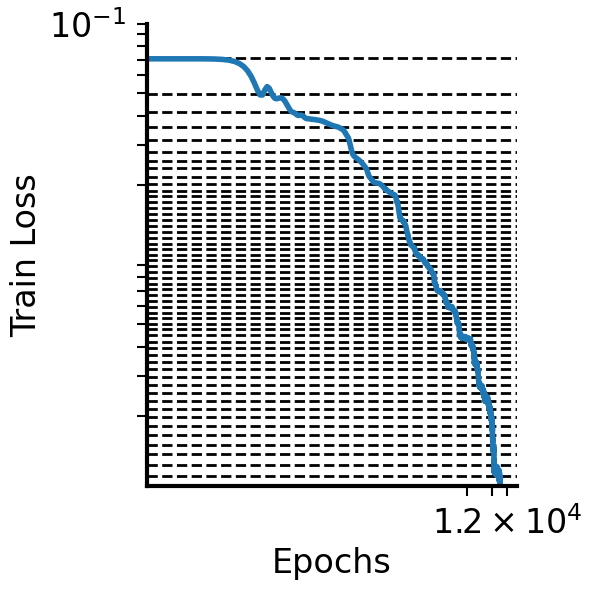

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(list(loss_history), lw=4)


# === Compute power spectrum of template ===
p = int(np.sqrt(len(template)))
print("p:", p)
x_freq, y_freq, power = theory.get_power_2d(template.reshape((p, p)))
print(power)
print(x_freq)
print(y_freq)
power = power.flatten()

valid = power > 1e-20
power = power[valid]
sorted_idx = np.argsort(power)[::-1]  # np.argsort with [::-1] gives descending order
power = power[sorted_idx]

# Plot theoretical lines
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / (p * p)

# alpha_values = get_alpha_values(template)

for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef*alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-3, 0.1])

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

viz.style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

In [ ]:
importlib.reload(theory)

# === SETTINGS ===
print("p =", p)
pxp = p * p
num_freqs = pxp // 2 + 1

# Compute template power spectrum (flattened 2D)
template_2d = template.reshape((p, p))
template_ft_2d = np.fft.rfft2(template_2d)
# template_power_2d = np.abs(template_ft_2d).flatten()[:num_freqs]

# === Compute power spectrum of template ===
freqs_u, freqs_v, template_power = theory.get_power_2d(template_2d)
freq = np.array([(u, v) for u in freqs_u for v in freqs_v])
print("freq shape:", freq.shape)
print("power shape:", template_power.shape)
# freq_flattened = freq.flatten()
# print("freq_flattened shape:", freq_flattened.shape)
flattened_template_power = template_power.flatten()
print("Template power shape:", flattened_template_power.shape)

alpha_values, flattened_filtered_template_power, valid_flattened_power_indices, sorted_valid_idx = theory.get_alpha_values_and_valid_freq(template)


# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

print(len(template_power.flatten()))
model_inputs = X_tensor
model_powers_over_time, steps = theory.model_power_over_time(model, param_history, model_inputs, len(template_power.flatten()), p) # models_powers_over_time shape: (num_steps, num_freqs), includes all frequencies in rfft

# Create a new figure for this plot
plt.figure(figsize=(10, 6))

for i in range(len(freq)):
    color = colors[i] if i < len(colors) else colors[0]
    label = fr"$\xi = ({freq[i][0]:.1f}, {freq[i][1]:.1f})$"
    plt.plot(steps, model_powers_over_time[:, i], color=color, lw=3, label=label)
    plt.axhline(flattened_template_power[i], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)

# Labeling and formatting
plt.xscale('log')
plt.yscale('log')
plt.xlim(0, len(param_history) - 1)
plt.ylim(1e-7, 2)
plt.xticks([1000, 10000, 100000, len(param_history) - 1], ['$10^3$', '$10^4$', '$10^5$', 'Final'])
plt.ylabel("Power", fontsize=24)
plt.xlabel("Epochs", fontsize=24)
plt.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.9), labelspacing=0.25)

# Use the current axes for styling
ax = plt.gca()
viz.style_axes(ax)
ax.grid(False)
plt.tight_layout()
# plt.savefig("fourier_power_only.png", bbox_inches="tight")
plt.show()

p = 12
freq shape: (84, 2)
power shape: (12, 7)
Template power shape: (84,)
[[3.42387546e-34 3.12218523e+00 5.15837278e-01 5.36330445e-02
  1.48303275e-01 2.31572234e-02 3.14010231e-04]
 [1.19933385e+00 7.88977577e-01 2.68867124e-01 2.24161203e-01
  1.16435478e-01 6.38257791e-03 1.93869689e-02]
 [1.89945846e-01 1.45722006e-01 2.78964854e-01 3.42176846e-01
  1.21071688e-01 8.96879023e-03 3.71564947e-02]
 [3.86636141e-02 2.10039168e-02 2.02626256e-02 2.76941247e-02
  3.45605557e-02 4.12709797e-02 3.52646914e-02]
 [1.00360906e-01 1.20294370e-01 1.37480928e-01 1.30646421e-01
  8.32693549e-02 2.34345246e-02 2.05685857e-03]
 [8.18471448e-02 6.71912538e-02 3.20630791e-02 9.50492347e-03
  8.42309200e-03 1.21834019e-02 8.19403405e-03]
 [2.33886573e-02 4.04648648e-02 2.68898221e-02 1.48961627e-02
  7.43278597e-03 3.09286463e-03 1.48533352e-03]
 [0.00000000e+00 5.59921367e-02 1.65288001e-02 4.02245764e-04
  2.10848937e-03 3.89068006e-03 8.19403405e-03]
 [0.00000000e+00 7.71518344e-02 3.90544720e-

KeyboardInterrupt: 

## Plot outputs

In [ ]:
idx = 4  # Index of the example to visualize
viz.plot_model_outputs(model, X, Y, idx, num_samples=5, save_path=None)

AttributeError: module 'gagf.viz' has no attribute 'plot_model_outputs'

## Plot Weights

In [ ]:
neurons_to_plot = list(range(20))
print(f"Neurons to plot: {neurons_to_plot}")
viz.plot_neuron_weights(model, neurons_to_plot, p, save_path=None, show=True)